# Linear Regression on a filtered dataset

<a id='Index'></a>
# Exercise list:
* <a href='#Exercise-01'>Exercise-01</a>
* <a href='#Exercise-02'>Exercise-02</a>
* <a href='#Exercise-03'>Exercise-03</a>
* <a href='#Exercise-04'>Exercise-04</a>

In [1]:
%spark 16 32g

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/17 17:13:52 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.4.2
      /_/

Using Python version 3.9.18 (main, Dec 15 2023 17:48:57)
Spark context Web UI available at None
Spark context available as 'sc' (master = local[*], app id = local-1760714033797).
SparkSession available as 'spark'.


In [2]:
%run handlers.ipynb

Pandas version:  2.1.4


# Read-in Manipulation DataFrames 

* Read in as .csv files the DataFrames **produced in the DataManipulation** Notebook.
* Pre-saved data are in the read-only directory **local_data_dir_ro**. Data you produced are in **local_data_dir**.
* Goal is to obtain the training and test DataFrames df_train and df_test.

In [3]:
df_names= ['df_train'+suffix_s_w+'.csv', \
           'df_test'+suffix_s_w+'.csv']

path_lustre = []
for filename in df_names:
    path_lustre.append(os.path.join(local_data_dir_ro, filename))

print("Reading in all DataFrames from manipulation in... ")
start_time = time.time()

df_train = spark.read.option('header', True).option('inferSchema', True).csv(os.path.join(LustrePrefix,path_lustre[0])).cache()
df_test = spark.read.option('header', True).option('inferSchema', True)\
    .csv(os.path.join(LustrePrefix,path_lustre[1])).cache()

print("--- %.0f min. %.2f sec.---" % (np.floor_divide(time.time() - start_time, 60),
    np.remainder(time.time() - start_time, 60)))

Reading in all DataFrames from manipulation in... 


25/10/17 17:14:11 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


--- 0 min. 10.62 sec.---


In [4]:
# Have a look at the training DataFrame:
df_train.printSchema()
#print('Number of entries (rows) in df_train:', df_train.count())

root
 |-- MONAT: integer (nullable = true)
 |-- TAG: integer (nullable = true)
 |-- STUNDE_SOLL: integer (nullable = true)
 |-- MINUTE_RANGE: integer (nullable = true)
 |-- ZUGEREIGNIS_LINIE: integer (nullable = true)
 |-- SERVICE_START_ZEIT: integer (nullable = true)
 |-- ZUGEREIGNIS_ISTZEIT: integer (nullable = true)
 |-- ZUGEREIGNIS_TYP: integer (nullable = true)
 |-- ZUGEREIGNIS_SOLLZEIT: integer (nullable = true)
 |-- SERVICE_ID: long (nullable = true)
 |-- ZUGEREIGNIS_ZUGNUMMER: integer (nullable = true)
 |-- ZUGEREIGNIS_DS100: string (nullable = true)
 |-- MINUTE_SOLL: integer (nullable = true)
 |-- STUNDE_SER: integer (nullable = true)
 |-- MINUTE_SER: integer (nullable = true)
 |-- WOCHENTAG_SER: string (nullable = true)
 |-- WOCHENTAG_SOLL: string (nullable = true)
 |-- VERSPAETUNG: integer (nullable = true)
 |-- LAUFSZEIT: integer (nullable = true)
 |-- Datum: timestamp (nullable = true)
 |-- Mittelwerte_Temperatur: double (nullable = true)
 |-- Mittelwerte_Rel_Feuchte: doub

# Prediction of the continuous delay with Linear Regression 

## Combinations of features
* The lists "columns to index" (col_to_inx) and "columns index" (col_inx) contain the same features (respectively without or with the "_index" suffix).
* **A different order of the two lists** does **not** have an impact on the LR algorithm.


* These feature combinations are ordered **from best to worst** prediction result (columns_index5, 4, 3, 2, 1), according to previous tests.

In [5]:
# Delay at station -1,-2 + Duration and additional features + Weather:
col_to_inx5 = [ 'ZUGEREIGNIS_DS100',  'STUNDE_SOLL',\
                    'LAUFSZEIT', 'prev0_VERSPAETUNG', 'prev1_prev0_VERSPAETUNG', 'Mittel_NO', 'Mittel_WG', 'ZUGEREIGNIS_TYP']
col_inx5 = [ 'prev0_VERSPAETUNG_INDEX','prev1_prev0_VERSPAETUNG_INDEX', 'ZUGEREIGNIS_DS100_INDEX', 'ZUGEREIGNIS_TYP_INDEX', \
                 'STUNDE_SOLL_INDEX', 'LAUFSZEIT_INDEX','Mittel_WG_INDEX', 'Mittel_NO_INDEX']

# Only delay at station -1,-2:
col_to_inx4 = ['prev0_VERSPAETUNG', 'prev1_prev0_VERSPAETUNG']
col_inx4 = ['prev0_VERSPAETUNG_INDEX', 'prev1_prev0_VERSPAETUNG_INDEX']

# Only delay at station -1:
col_to_inx3 = ['prev0_VERSPAETUNG']
col_inx3 = ['prev0_VERSPAETUNG_INDEX']

# Basic information of the original dataset (without additional features) + Weather information:
col_to_inx2 = ['ZUGEREIGNIS_ZUGNUMMER', 'ZUGEREIGNIS_DS100', 'SERVICE_START_ZEIT', \
                  'Mittelwerte_Temperatur', 'Mittel_WG', 'ZUGEREIGNIS_SOLLZEIT',\
                    'Summe_Niederschalg', 'Mittel_NO', 'Mittel_NO2', 'Mittel_O3', 'Mittel_PM10']
col_inx2 = ['ZUGEREIGNIS_ZUGNUMMER_INDEX', 'ZUGEREIGNIS_DS100_INDEX', 'SERVICE_START_ZEIT_INDEX', \
                 'Mittelwerte_Temperatur_INDEX', 'ZUGEREIGNIS_SOLLZEIT_INDEX',\
                  'Mittel_WG_INDEX',  'Summe_Niederschalg_INDEX', 'Mittel_NO_INDEX', \
                    'Mittel_NO2_INDEX', 'Mittel_O3_INDEX', 'Mittel_PM10_INDEX']

# Basic information of the original dataset:
col_to_inx1 = ['ZUGEREIGNIS_ZUGNUMMER', 'ZUGEREIGNIS_DS100', 'SERVICE_START_ZEIT', \
                  'ZUGEREIGNIS_SOLLZEIT', 'SERVICE_ID']
col_inx1 = ['ZUGEREIGNIS_ZUGNUMMER_INDEX', 'ZUGEREIGNIS_DS100_INDEX', 'SERVICE_START_ZEIT_INDEX', \
                  'ZUGEREIGNIS_SOLLZEIT_INDEX', 'SERVICE_ID_INDEX']

col_to_inx_list = []
col_to_inx_list.append(col_to_inx1)
col_to_inx_list.append(col_to_inx2)
col_to_inx_list.append(col_to_inx3)
col_to_inx_list.append(col_to_inx4)
col_to_inx_list.append(col_to_inx5)

col_inx_list = []
col_inx_list.append(col_inx1)
col_inx_list.append(col_inx2)
col_inx_list.append(col_inx3)
col_inx_list.append(col_inx4)
col_inx_list.append(col_inx5)

# Strategies to improve the prediction outcome:
# Linear Regression on a filtered dataset

* In the exercises, we used 5 different combinations of feature columns using the whole dataset (= all samples).
* Now, we restrict the dataset by **filtering** the feature columns.
* New linear regression models are built, based on:
  * **ONE** combination of feature columns (the best performing one in the previous steps), and
  * **FOUR** filters.

<a href='#Index'>Exercise Index</a>
<a id='Exercise-01'></a>

**EXERCISE 1**

**Filter out some data** to try to improve the result outcome:
* **df_train_filter** and **df_test_filter** are (empty) lists of DataFrames.
* Add elements to the lists using the approprate <a href=https://docs.python.org/3/tutorial/datastructures.html>python function</a>.


* We filter the DataFrames df_train and df_test using the function <a href='https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.filter.html?highlight=filter#pyspark.sql.DataFrame.filter'>filter</a> correctly,


* ... and generate 4 new pairs of DataFrames by filtering the colummns:

  * ZUGEREIGNIS_LINIE to select line 1,
  * WOCHENTAG_SOLL to select Wednesdays ("Wed"),
  * VERSPAETUNG to select delays greater than 5 minutes,
  * and also concatenating these 3 filters one after the other (i.e., journeys on the line 1 on Wednesdays with a delay >= 5 mins).

In [6]:
df_train_filter = []
df_test_filter  = []

# S1 line only
df_train_filter.append(df_train.filter(df_train.ZUGEREIGNIS_LINIE == "1"))
df_test_filter.append(df_test.filter(df_test.ZUGEREIGNIS_LINIE == "1"))

# Wednesday only
df_train_filter.append(df_train.filter(df_train.WOCHENTAG_SOLL == "Wed"))
df_test_filter.append(df_test.filter(df_test.WOCHENTAG_SOLL == "Wed"))

# Delay >= 5 minutes only
df_train_filter.append(df_train.filter(df_train.VERSPAETUNG >= 5))
df_test_filter.append(df_test.filter(df_test.VERSPAETUNG >= 5))




In [7]:
# All of the above filters
df_train_filter.append(df_train.filter(df_train.ZUGEREIGNIS_LINIE == "1").filter(df_train.WOCHENTAG_SOLL == "Wed").filter(df_train.VERSPAETUNG >= 5))
df_test_filter.append(df_test.filter(df_test.ZUGEREIGNIS_LINIE == "1").filter(df_test.WOCHENTAG_SOLL == "Wed").filter(df_test.VERSPAETUNG >= 5))

* **Check** that both generated lists have size **4**!

In [8]:
print(len(df_train_filter))
print(len(df_test_filter))

4
4


## Training of the model
* Run the Linear Regression ML-Pipelines.
* **Fit the model** for all defined combinations of feature columns.
* Output: **eva_X, model_X** = evaluator and model that will be applied to the test DataFrame for prediction.

## Important remark:
* **local_ml_dir_ro** = read-only directory (contains pre-saved models).
* **local_ml_dir**    = write-directory (where trained models are saved if training is executed).

In [9]:
if (True):
    for i in (range(len(df_train_filter))): # Loop over the applied filters
        print("Running linreg filter pipeline " + str(i+1) + "...")
        start_time = time.time()
        eva_i, model_i  = MLPipeline_LR.linReg(df_train_filter[i], col_to_inx_list[4], col_inx_list[4])
        path=os.path.join(local_ml_dir, 'linRegModel_featFilter'+str(i+1)+suffix_s_w)
        model_i.bestModel.write().overwrite().save(os.path.join(LustrePrefix,path))
        
        print("--- %.0f min. %.2f sec.---" % (np.floor_divide(time.time() - start_time, 60),
                                              np.remainder(time.time() - start_time, 60)))

Running linreg filter pipeline 1...


25/10/17 17:17:17 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/10/17 17:17:17 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
25/10/17 17:17:18 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


--- 2 min. 50.00 sec.---
Running linreg filter pipeline 2...
--- 2 min. 19.87 sec.---
Running linreg filter pipeline 3...
--- 2 min. 6.54 sec.---
Running linreg filter pipeline 4...
--- 2 min. 4.49 sec.---


* Apply the trained model to the filtered test datasets. Then, a plot is produced to see how the original result changes.

<a href='#Index'>Exercise Index</a>
<a id='Exercise-02'></a>

**EXERCISE 2**
* Define the **Evaluator** for our model with the function RegressionEvaluator().
* The target or label column is the delay (**"VERSPAETUNG"**).
* The prediction will be stored in a new column (**"prediction"**).
* The chosen Evaluator is the root mean squared error (**"rmse"**).

In [11]:
# Read-in and evaluate the model
modelEval = RegressionEvaluator(labelCol="VERSPAETUNG", predictionCol="prediction", metricName="rmse")

<a href='#Index'>Exercise Index</a>
<a id='Exercise-03'></a>

**EXERCISE 3**
* The fitted model has been either produced with training in the blocks above and saved, or previously stored. It can now be **loaded**.


* **Obtain model_i** as follows:
  * Use PipelineModel.load(__) to read-in the fitted model 'linRegModel_featFilter **_i+1**'.
* The RMSE on the test dataset is computed with the function linRegTest defined in the Handlers.
  * This function applies the model to the test DataFrame and evaluates the result.

* Also define the **labels** for the plot (next blocks), by adding the corresponding number of filter applied (depends on the loop iterator **i**).

Filter n. 1


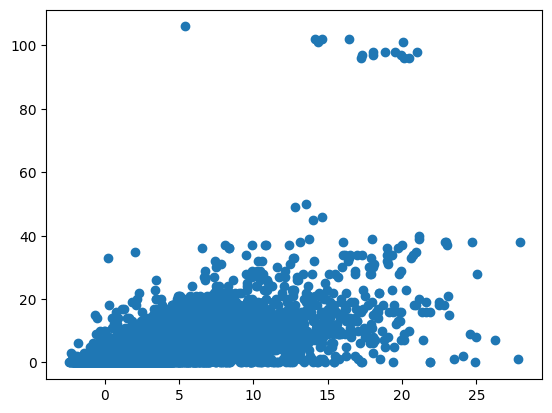

Root Mean Squared Error (RMSE) on data = 2.34292
[2.342921077834592]
--- Evaluated filtered regression model 1  ---
Filter n. 2


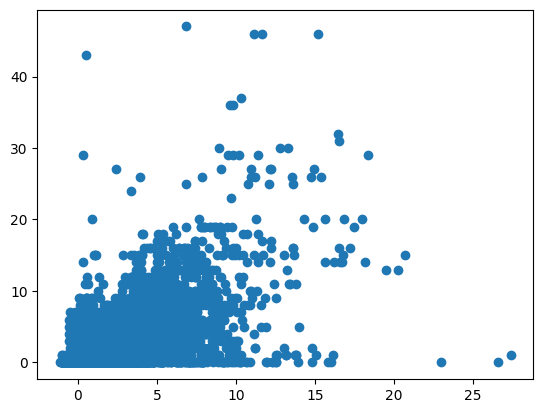

Root Mean Squared Error (RMSE) on data = 1.49615
[2.342921077834592, 1.4961531524198937]
--- Evaluated filtered regression model 2  ---
Filter n. 3


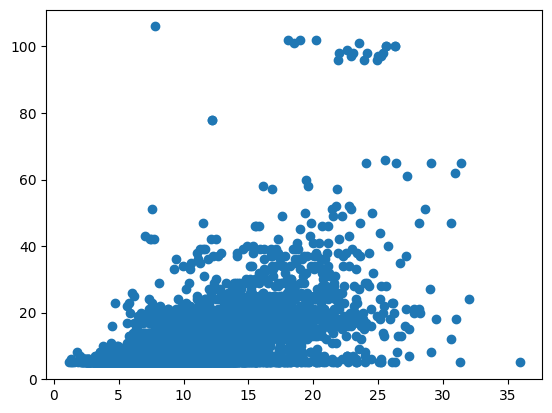

Root Mean Squared Error (RMSE) on data = 4.3488
[2.342921077834592, 1.4961531524198937, 4.348801697244345]
--- Evaluated filtered regression model 3  ---
Filter n. 4


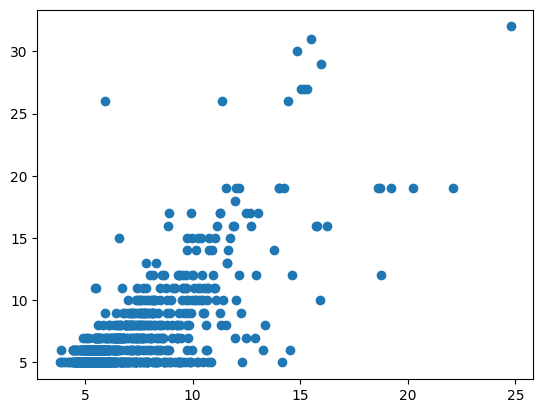

Root Mean Squared Error (RMSE) on data = 2.4571
[2.342921077834592, 1.4961531524198937, 4.348801697244345, 2.4570997179382577]
--- Evaluated filtered regression model 4  ---
--- 0 min. 24.90 sec.---


In [12]:
rmse_list_test = []  # Collect the RMSE for each model on the test dataset
labels = []          # Labels for the barplot

start_time = time.time()
for i in (list(range(len(df_train_filter)))):  # Change accordingly to number of filters
    print('Filter n.', i+1)
    path = os.path.join(LustrePrefix, local_ml_dir, 'linRegModel_featFilter' + str(i+1) + suffix_s_w)

    model_i = PipelineModel.load(path)

    rmse_test = MLPipeline_LR.linRegTest(df_test_filter[i], modelEval, model_i)

    filter_num = str(i+1)
    labels.append('Filter ' + filter_num)
    rmse_list_test.append(rmse_test)

    print(rmse_list_test)
    print("--- Evaluated filtered regression model " + filter_num + "  ---")

print("--- %.0f min. %.2f sec.---" % (np.floor_divide(time.time() - start_time, 60),
                                    np.remainder(time.time() - start_time, 60)))

## Plot the resulting RMSE as a barplot

<a href='#Index'>Exercise Index</a>
<a id='Exercise-04'></a>

**EXERCISE 4**
* Each bar displays the **RMSE** for one of the **4 models** applied on the corresponding test data.
* Complete with the correct labels:
  * Label the y-axis.
  * Rename the x-axis ticks with the labels defined in loop above.

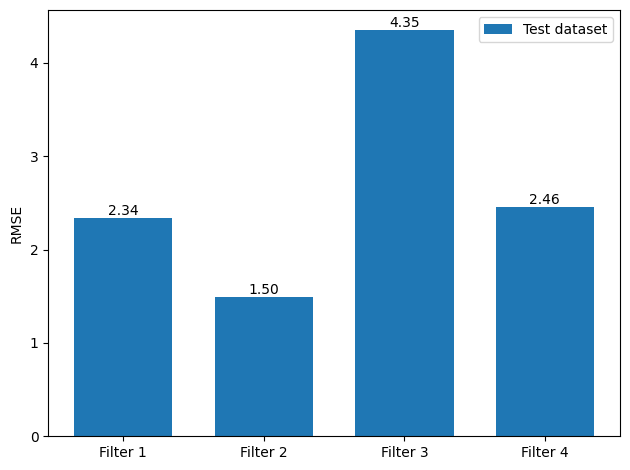

In [13]:
rmse_list_test_feat_var = rmse_list_test # RMSE for each model on the test dataset

x = np.arange(len(labels))  
width = 0.35*2 

fig, ax = plt.subplots()
rects = ax.bar(x, rmse_list_test_feat_var, width, label='Test dataset')

ax.set_ylabel('RMSE')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.bar_label(rects, labels=['%.2f' % e for e in rmse_list_test_feat_var])
ax.legend()

fig.tight_layout()

filename = 'Filter_testonly_rmse_bar_'+ suffix_s_w
path = os.path.join(LustrePrefix, local_regression_plot_dir, filename)
plt.savefig(path)